# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 23 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 23 октября, -4 балла после 06:00 30 октября, -6 баллов после 06:00 6 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

###### Задание 1 (4 балла)
Реализовать алгоритм кластеризации, который относится к вашему варианту. Проверить работоспособность алгоритма на "Iris". Сравните свой алгоритм кластеризации с алгоритмом из scikit-learn по времени выполнения, используя timeit. Ваша реализация не должна работать сильно дольше, а в идеале должна быть даже немного быстрее.

###### Задание 2 (2 балла)
Выбрать, имплементировать и использовать критерий качества.

###### Задание 3 (3балла)
Применить алгоритм кластеризации к данным по странам.   
Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам.   
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   
Также необходимо показать, какие страны попали в общий кластер.
Визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время.

###### Задание 4 (1 балл)
Опишите в выводе почему и какие страны попали в общий кластер.

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

from __future__ import print_function, division

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')


## Реализация алгоритма

In [3]:
N = 24 # put your index here


In [4]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print (u"Реализуем алгоритм кластеризации '%s'" % my_algorithm)


Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

## Задание 1

In [6]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.stats import multivariate_normal
from numpy.core.umath_tests import matrix_multiply

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according.
    """
    
    def __init__(self, k, random_state = 2, max_iter = 25, epsilon = 1e-5):
        
        self.k = k
        self.random_state = random_state
        self.max_iter = max_iter
        self.epsilon = epsilon
        
        # Математическое ожидание μ, ковариационная матрица Σ и апостериорная вероятность π.
        self.mu = []
        self.covariance = []
        self.pi = []
        
        
    def fit(self, X):
        """
        Use data matrix x to compute model parameters.
        """
        np.random.seed(self.random_state)
        
        # Из k-means++ бёрем способ более качественной инициализации центроидов,
        # роль которых в случае нормального распределения играют значения математического ожидания.
        self.mu.append(X[np.random.choice(len(X), 1)[0]])
        
        for j in range(1, self.k):
            d_x2 = np.array(np.min(cdist(X, self.mu[:j]) ** 2, axis = 1))
            
            Sum = np.sum(d_x2) * np.random.rand()
            Sum2 = 0
            
            for i in range(len(X)):
                Sum2 += d_x2[i]
                
                if Sum2 > Sum:
                    self.mu.append(X[i])
                    break
        
        # Covariance matrix of the distribution (default one).
        self.covariance = np.array([np.eye(len(X[0])) for i in range(self.k)])             
        self.pi = np.ones(self.k) / self.k
        
        old_likelihood_func = 0
        
        for it in range(self.max_iter): 
    
            # Expectation.
        
            gammas = np.zeros((self.k, len(X)))
                
            for j in range(self.k):
                
                gammas[j, :] = self.pi[j] * multivariate_normal.pdf(X, allow_singular=True, mean = self.mu[j], 
                                                                        cov = self.covariance[j])
            
            gamma_Sum = np.sum(gammas, axis = 0)
            gammas /= gamma_Sum
            
            # Проверка на сходимость функции правдоподобия.
            likelihood_func = np.sum(np.array(gamma_Sum))
            
            if (abs(old_likelihood_func - likelihood_func) < self.epsilon):
                
                return self

            old_likelihood_func = likelihood_func

            # Maximization.
            
            N = np.sum(gammas, axis = 1)
            
            # Пересчёт математического ожидания и апостериорной вероятности.
            self.mu = np.dot(gammas[:], X) / N[:, None]
            self.pi = N[:, None] / len(X)
            
            self.covariance = np.array([np.zeros([len(X[0]), len(X[0])]) for i in range(self.k)])
            
            # Пересчёт элементов матрицы ковариации.
            for i in range(self.k):
                
                for j in range(len(X)):
                    self.covariance[i] += gammas[i, j] * np.outer(X[j] - self.mu[i], X[j] - self.mu[i])
                
                self.covariance[i] /= N[i]
        
        return self
    
    
    def plot(self, X):
        
        plt.figure(figsize=(6, 6))
        plt.xlim([-10, 10])
        plt.ylim([-10, 10])
        plt.grid()
        
        plt.scatter(X[:, 0], X[:, 1], c = y)
        plt.scatter(self.mu[:, 0], self.mu[:, 1])
    
    
    def predict(self, X):
        """
        Using computed model parameters predict cluster for all objects from x.
        """
        clusters = list()
        
        for j in range(len(X)):
            
            clust_num = np.argmax([self.pi[i] * multivariate_normal.pdf(X[j], allow_singular=True, 
                                                mean = self.mu[i], cov = self.covariance[i]) for i in range(self.k)])
            clusters.append(clust_num)
        
        return clusters
    
    
    def mu(self):
        
        return self.mu
    
    
    def fit_predict(self, X):
        
        self.fit(X)
        
        return self.predict(X)


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

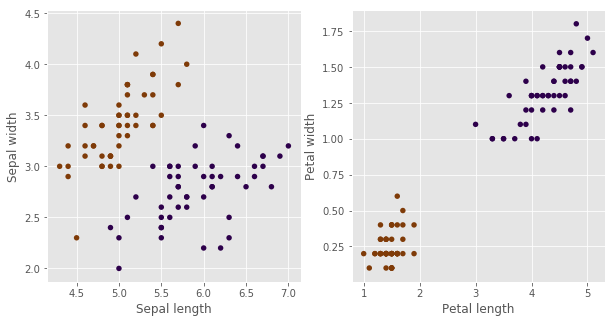

In [7]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()


In [8]:
model = Clustering(k = 2, max_iter = 25, epsilon = 1e-5)
model.fit(x_iris)
y_hat = model.predict(x_iris)


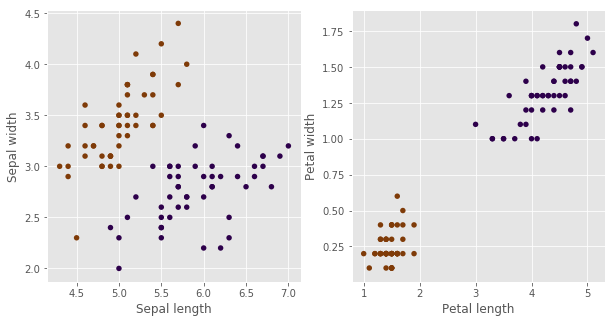

In [9]:
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_hat, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_hat, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()


Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [10]:
pred_iris = Clustering(k=2, max_iter=5).fit_predict(x_iris)

print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))


Adjusted Rand index for iris is: 1.00


#### Проверка на простых данных

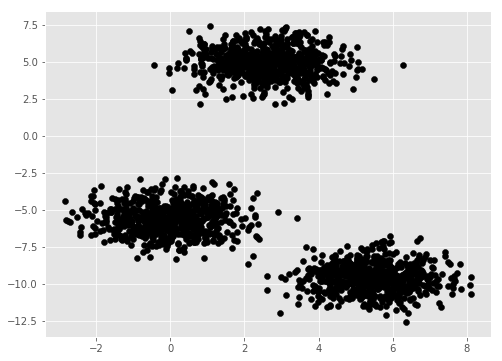

In [12]:
from sklearn import datasets

n = 2000
blobs = datasets.make_blobs(n_samples=n, random_state=10)

plt.figure(figsize=(8, 6));

X, y = blobs
plt.scatter(X[:, 0], X[:, 1], c='k');


In [17]:
%%time

model = Clustering(k = 3, max_iter = 10, epsilon = 0.01, random_state = 10)
model.fit(X)

Centroids = model.predict(X)


Wall time: 2.18 s


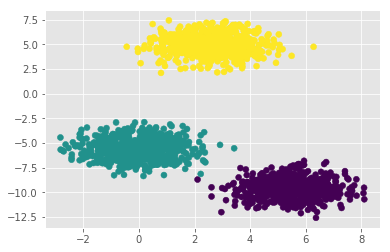

In [18]:
plt.scatter(X[:, 0], X[:, 1], c = Centroids);


In [20]:
from sklearn.mixture import GaussianMixture


In [21]:
%%time

model = GaussianMixture(n_components=3)
model.fit(X)

Centroids = model.predict(X)


Wall time: 41 ms


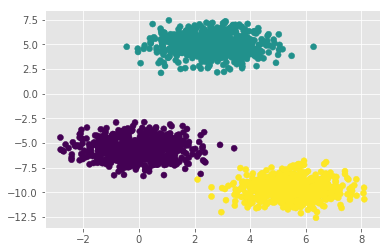

In [22]:
plt.scatter(X[:, 0], X[:, 1], c = Centroids);


На простых данных всё корректно, правда стоит отметить, что написанная программа работает значительно медленнее.

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Silhouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

## Задание 2

In [23]:
# Инерция - сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида.

def quality(x, y): 
    """
    Implement quality criterion of your choice
    """
    set(y)
    clusters = [[] for i in set(y)]
    
    for i in range(len(x)):
        clusters[y[i]].append(x[i])
    Sum = 0
    
    for i in range(len(clusters)):
        # Cовпадает с центрами смесей нормальных распределений.
        Middle = np.mean(clusters[i], axis = 0)
        Sum += np.sum([np.sum((Middle-ob) ** 2) for ob in clusters[i]])
    
    return Sum


Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

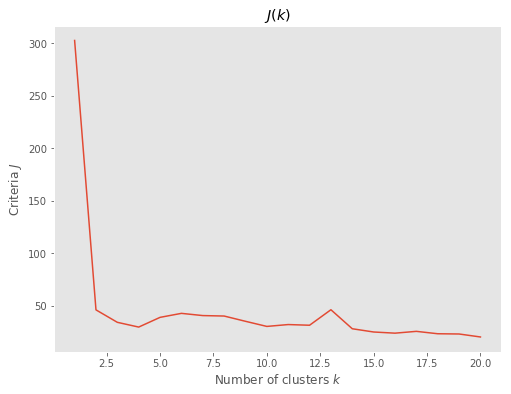

In [24]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k, max_iter = 50, epsilon = 1e-2, random_state = 1)
    y = cls.fit_predict(x_iris)
    criteria[i] = quality(x_iris, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()


## Задание 3

In [25]:
df = pd.read_csv('WDIData.csv')


In [27]:
import pandas as pd

year = '1975'

df = df[['Country Name', 'Indicator Name', year]]
df = df.dropna(axis=0)
df = df[year].groupby([df['Country Name'], df['Indicator Name']]).sum().unstack()

df.head(5)


Indicator Name,"Adjusted net enrollment rate, primary (% of primary school age children)","Adjusted net enrollment rate, primary, female (% of primary school age children)","Adjusted net enrollment rate, primary, male (% of primary school age children)",Adjusted net national income (annual % growth),Adjusted net national income (constant 2010 US$),Adjusted net national income (current US$),Adjusted net national income per capita (annual % growth),Adjusted net national income per capita (constant 2010 US$),Adjusted net national income per capita (current US$),"Adjusted net savings, excluding particulate emission damage (% of GNI)",...,"Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)",Urban population,Urban population (% of total),Urban population growth (annual %),"Use of IMF credit (DOD, current US$)","Vulnerable employment, total (% of total employment)","Wage and salaried workers, total (% of total employment)",Wholesale price index (2010 = 100)
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,2.282568e+09,NaN,NaN,181.295929,NaN,...,NaN,NaN,NaN,1710139.0,13.583,5.405036,0.0,NaN,NaN,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,786668.0,32.712,2.902126,0.0,NaN,NaN,NaN
Algeria,NaN,NaN,NaN,-0.673453,3.841624e+10,1.268969e+10,-3.419709,2299.121254,759.448109,NaN,...,NaN,NaN,NaN,6738780.0,40.330,3.218768,0.0,NaN,NaN,NaN
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21657.0,72.354,2.029035,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26791.0,87.252,5.343495,NaN,NaN,NaN,NaN


In [28]:
# Проход по названиям столбцов.

for i in df.columns:
    df[i].fillna(df[i].mean(), inplace = True)

df.head()


Indicator Name,"Adjusted net enrollment rate, primary (% of primary school age children)","Adjusted net enrollment rate, primary, female (% of primary school age children)","Adjusted net enrollment rate, primary, male (% of primary school age children)",Adjusted net national income (annual % growth),Adjusted net national income (constant 2010 US$),Adjusted net national income (current US$),Adjusted net national income per capita (annual % growth),Adjusted net national income per capita (constant 2010 US$),Adjusted net national income per capita (current US$),"Adjusted net savings, excluding particulate emission damage (% of GNI)",...,"Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)",Urban population,Urban population (% of total),Urban population growth (annual %),"Use of IMF credit (DOD, current US$)","Vulnerable employment, total (% of total employment)","Wage and salaried workers, total (% of total employment)",Wholesale price index (2010 = 100)
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,69.171311,62.990499,74.260767,1.886391,1.477101e+12,2.282568e+09,0.032143,8351.246202,181.295929,13.499778,...,15.501667,12.436666,13.876666,1710139.0,13.583,5.405036,0.000000e+00,9.66,90.339996,23.046081
Albania,69.171311,62.990499,74.260767,1.886391,1.477101e+12,3.369399e+11,0.032143,8351.246202,1937.758252,13.499778,...,15.501667,12.436666,13.876666,786668.0,32.712,2.902126,0.000000e+00,9.66,90.339996,23.046081
Algeria,69.171311,62.990499,74.260767,-0.673453,3.841624e+10,1.268969e+10,-3.419709,2299.121254,759.448109,13.499778,...,15.501667,12.436666,13.876666,6738780.0,40.330,3.218768,0.000000e+00,9.66,90.339996,23.046081
American Samoa,69.171311,62.990499,74.260767,1.886391,1.477101e+12,3.369399e+11,0.032143,8351.246202,1937.758252,13.499778,...,15.501667,12.436666,13.876666,21657.0,72.354,2.029035,1.370315e+08,9.66,90.339996,23.046081
Andorra,69.171311,62.990499,74.260767,1.886391,1.477101e+12,3.369399e+11,0.032143,8351.246202,1937.758252,13.499778,...,15.501667,12.436666,13.876666,26791.0,87.252,5.343495,1.370315e+08,9.66,90.339996,23.046081


In [29]:
country_name = np.array(list(df.axes[0]))
array_df = np.array(df)


Импортируем T-SNE.

In [30]:
from sklearn.manifold import TSNE

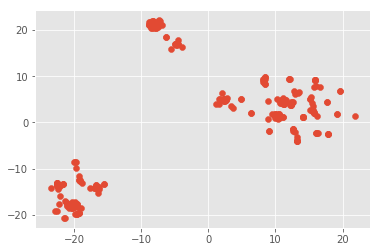

In [31]:
array_embedded = TSNE(n_components=2).fit_transform(array_df)
plt.scatter(array_embedded[:, 0], array_embedded[:, 1]);


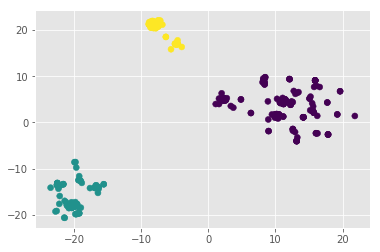

In [32]:
model = Clustering(k = 3, max_iter = 30, epsilon = 0.00001, random_state = 2)
model.fit(array_embedded)

y_predict = model.predict(array_embedded)
plt.scatter(array_embedded[:, 0], array_embedded[:, 1], c = y_predict);


Кластеризация прошла успешно.

In [33]:
Countries = [[] for i in range(len(set(y_predict)))]

for i in range(len(y_predict)):
    Countries[y_predict[i]].append(country_name[i])
    

In [34]:
# Кластер 0.

for j in range(len(Countries[0])):
    print(Countries[0][j])


Afghanistan
Albania
American Samoa
Angola
Antigua and Barbuda
Arab World
Armenia
Aruba
Azerbaijan
Bahrain
Barbados
Belarus
Bhutan
Bosnia and Herzegovina
British Virgin Islands
Bulgaria
Cabo Verde
Cambodia
Caribbean small states
Cayman Islands
Central Europe and the Baltics
Channel Islands
Chile
Colombia
Comoros
Croatia
Curacao
Czech Republic
Djibouti
Dominica
Early-demographic dividend
East Asia & Pacific
East Asia & Pacific (IDA & IBRD countries)
East Asia & Pacific (excluding high income)
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Euro area
Europe & Central Asia
Europe & Central Asia (IDA & IBRD countries)
Europe & Central Asia (excluding high income)
European Union
Faroe Islands
Fragile and conflict affected situations
Gibraltar
Grenada
Guam
Guinea
Haiti
Heavily indebted poor countries (HIPC)
High income
Hungary
IBRD only
IDA & IBRD total
IDA blend
IDA only
IDA total
Indonesia
Iran, Islamic Rep.
Iraq
Isle of Man
Japan
Kazakhstan
Korea, Dem. People’s Rep.
Korea, Rep.
Kosovo
Kyrgyz Re

In [35]:
# Кластер 1.

for j in range(len(Countries[1])):
    print(Countries[1][j])


Algeria
Argentina
Australia
Austria
Bangladesh
Belgium
Benin
Bolivia
Botswana
Brazil
Burkina Faso
Cameroon
Canada
Chad
Congo, Dem. Rep.
Congo, Rep.
Costa Rica
Cuba
Cyprus
Denmark
Dominican Republic
Ecuador
Egypt, Arab Rep.
El Salvador
Fiji
Finland
France
Gabon
Gambia, The
Germany
Greece
Guatemala
Honduras
Hong Kong SAR, China
Iceland
India
Ireland
Italy
Kenya
Lesotho
Luxembourg
Madagascar
Malaysia
Mali
Mauritania
Mexico
Morocco
Netherlands
Nicaragua
Norway
Pakistan
Panama
Papua New Guinea
Peru
Philippines
Portugal
Puerto Rico
Rwanda
Senegal
Sierra Leone
Singapore
Somalia
South Africa
Spain
Sri Lanka
Sudan
Swaziland
Sweden
Syrian Arab Republic
Thailand
Togo
Trinidad and Tobago
Tunisia
United Kingdom
United States
Uruguay
Venezuela, RB


In [37]:
# Кластер 2.

for j in range(len(Countries[2])):
    print(Countries[2][j])


Andorra
Bahamas, The
Belize
Bermuda
Brunei Darussalam
Burundi
Central African Republic
China
Cote d'Ivoire
French Polynesia
Georgia
Ghana
Greenland
Guinea-Bissau
Guyana
Israel
Jamaica
Jordan
Kiribati
Kuwait
Liberia
Liechtenstein
Malawi
Malta
Monaco
Myanmar
Nepal
New Caledonia
Niger
Oman
Paraguay
San Marino
Saudi Arabia
Seychelles
St. Vincent and the Grenadines
Suriname
Tonga
Turkey
United Arab Emirates
Virgin Islands (U.S.)
Zambia
Zimbabwe


## Задание 4

Анализируя итоговую картинку, можно заметить, что наиболее компактно точки расположены в самом маленьком кластере. С учетом того, что в нём наблюдаются самые маленькие европейские страны, такие как Андорра, Лихтенштейн и Мальта, неразвитая Гренландия, а также слабо развитые страны Африки и Южной Америки, можно сделать вывод, что третий (2-ой) кластер представляет собой наименее приемлемые для жизни 1975-го года с экономической точки зрения страны. Немного выделяются из общей массы Китай, Монако, Израиль и Турция, но вполне допускаю, что для тех лет некоторые их ключевые "жизненные" показатели были на уровне ниже среднего. При этом даже этот наиболее компактный кластер содержит три явно выраженных "подкластера", наименьшие из которых, вероятно, и содержат эти четыре страны.

Видно, что второй по величине кластер (№ 1) содержит два "подкластера", а в его составе можно заметить такие страны как США, Великобритания, Испания, Португалия, Нидерланды, Италия, Греция, Германия, Бразилия, Аргентина, Бельгия. То есть формально для нынешней политико-экономической ситуации можно утверждать, что в него входят наиболее развитые страны Европы (Германия, Франция, Британия, Голландия), Северной и Южной Америки (США, Канада, Мексика, Бразилия, Аргентина, Уругвай). Плюс, наверное, самые часто посещаемые государства Европы (юго-запад) и страны Скандинавии: Швеция, Дания, Финляндия, Норвегия. А также, что важно, ЮАР и Австралия. С учетом Алжира, Камеруна и ещё некоторых других стран, о которых у меня всё-таки имеется некое представление, становится очевидно, что этот кластер характеризует бОльшую часть развитых государств мира со всех частей света, кроме, пожалуй, Азии.

Судя по скаттер-плоту, в нулевом кластере наблюдается достаточно сильный разброс, а согласно ранее проанализированным кластерам, тут располагаются так называемые "середнячки". Полагаю, под "общим" кластером именно этот и подразумевался. Для нынешних времён, наверное, Япония, Кореи, Нигерия и некоторые другие страны оказались бы в кластере №1, но в целом можно с уверенностью утверждать, что кластеризация вполне неплохо интерпретируется и частично соответствует даже современным реалиям.
